# Attention-Based Topics (ABT) 
# 1. Method implementation

In [1]:
!pip install wordcloud
!pip install -U sentence-transformers
!pip install gensim

In [3]:
from wordcloud import WordCloud

corpus = []
vocabulary = []    
topics = []
coherence = 0.0

class Topic:
    def __init__(self, index):
        self.index = index
        # self.sentences = []
        self.sentences = ""
        self.words = []
        self.coherence = 0.0
        self.wordcloud = WordCloud()
        self.number_of_sentences = 0


## Step 1: Sentence Modeling

In [4]:
import os.path

DATASET = 'clicr'
DATASET_PATH = '../datasets/'+DATASET+'/cases-titles.txt'

BERT_MODEL = 'bert-base-cased'
# BERT_MODEL = 'fagner/envoy'
# BERT_MODEL = "dmis-lab/biobert-base-cased-v1.1"
# BERT_MODEL = 'facebook/bart-base'
# BERT_MODEL = 'all-mpnet-base-v2'

OUTPUT_PATH = 'output/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += DATASET + '/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += BERT_MODEL + '/'
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH, exist_ok=True)

In [5]:
from sentence_transformers import SentenceTransformer

with open(DATASET_PATH) as f:
    corpus = f.readlines()
language_model = SentenceTransformer(BERT_MODEL)
vector_space = language_model.encode(corpus)

No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.
/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


<Figure size 640x480 with 0 Axes>

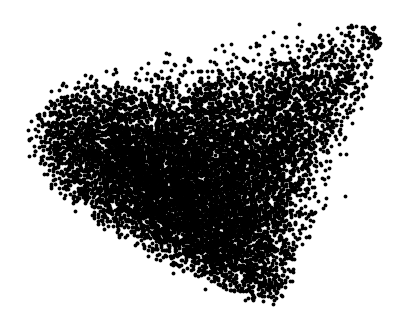

In [6]:
from matplotlib import pyplot as plt 
from sklearn import manifold

x_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(vector_space)
 
x = x_2d[:,0]
y = x_2d[:,1]

plt.clf()
plt.figure(figsize=(5, 4))
plt.scatter(x, y, color='black', s=3)
plt.rc('xtick', labelsize=4) 
plt.axis("off")
plt.savefig(OUTPUT_PATH + 'vector-space-'+str(BERT_MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='eps')

## Step 2: Hierarchical Sentence Aggregation

In [16]:
#BERT: 300, 100, 80, 62, 60, 55, 48, 41  40.25 40 17.85, 13.79  11.83, 10.5
#envoy: 450, 410, 310, 220, 160, 156.5, 150, 120 110 93, 36.5   24.9   20.3  17.69
#biobert: 200, 90, 77, 60, 55, 52.7, 52, 51.6 51 50 47 40 21.7 15.7 13.4537  11.8
#all-mpnet-base-v2: 150, 16, 15, 14, 13.5, 13, 11.8, 11, 10.4 10.3   4.88  3.805,   3.22  2.9035
#bart: 500, 400, 240, 230, 215, 210, 190, 177,  150, 140, 100  51.5   42.65  38.25

DISTANCE_THRESHOLD = 100

In [17]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(linkage='ward', distance_threshold=DISTANCE_THRESHOLD, n_clusters=None)
clustering_model = clustering_model.fit(vector_space)
k = clustering_model.n_clusters_

print('Distance Threshold: ', DISTANCE_THRESHOLD)
print('Resulting Clusters:',  k)

Distance Threshold:  100
Resulting Clusters: 2


<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

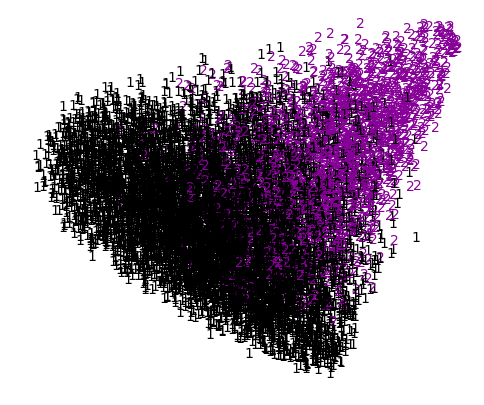

In [18]:
plt.clf()
plt.figure(figsize=(5, 4))
plt.figure(figsize=(6, 5))

for i, sentence in enumerate(corpus):
    plt.scatter(x[i], y[i], color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), s=0)
    plt.annotate(clustering_model.labels_[i]+1, (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=10)
    
if not os.path.exists(OUTPUT_PATH + str(k) + 'topics'): os.mkdir(OUTPUT_PATH + str(k) + 'topics')

plt.axis("off")
plt.savefig(OUTPUT_PATH + str(k) + 'topics/clusters-'+str(BERT_MODEL).replace('/','').replace('.','') + '.png', bbox_inches='tight', transparent=True)

### Topics Hierarchy

<Figure size 640x480 with 0 Axes>

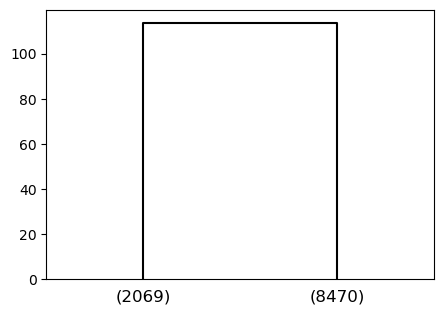

In [19]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

plt.clf()
plt.figure(figsize=(5,3.5))

counts = np.zeros(clustering_model.children_.shape[0])
n_samples = len(clustering_model.labels_)

for i, merge in enumerate(clustering_model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else: current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering_model.children_, clustering_model.distances_, counts]).astype(float)

r = dendrogram(linkage_matrix, truncate_mode='lastp', p=k, color_threshold=0, above_threshold_color='black')
# r = dendrogram(linkage_matrix, truncate_mode=None, above_threshold_color='black', color_threshold=0, no_labels=True)

# plt.axhline(c='black', linestyle='--', y=DISTANCE_THRESHOLD) 

plt.savefig(OUTPUT_PATH + str(k) + 'topics/dendrograma-'+str(BERT_MODEL).replace('/','').replace('.','')+'.png', bbox_inches='tight')

## Step 3: Representing Topics

In [20]:
MAX_DF = 0.1
c_MAX_DF = 0.9
TOP_WORDS = 50

In [21]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csc_matrix

topics = [Topic(i) for i in range(k)]
for i in range(len(corpus)):
    cluster_index = clustering_model.labels_[i]
    topics[cluster_index].sentences += corpus[i] + " "
    topics[cluster_index].number_of_sentences += 1

if (k > 1):
    c_tfidf_model = TfidfVectorizer(max_df=c_MAX_DF)
    c_tfidf = c_tfidf_model.fit_transform([topic.sentences for topic in topics])
    c_tfidf_matrix = c_tfidf.toarray()
    vocabulary = c_tfidf_model.get_feature_names_out()
    
    for i, topic in enumerate(topics):
        sorted_term_indexes = np.argsort(-1*c_tfidf_matrix[topic.index])
        topic.words = [vocabulary[j] for j in sorted_term_indexes]   
        
        dense = c_tfidf[topic.index].todense()
        lst1 = dense.tolist()
        tfidf_data_frame = pd.DataFrame(lst1, columns=vocabulary)
        topic.wordcloud = WordCloud(mode='RGBA', background_color="rgba(255, 255, 255, 0)", max_words=TOP_WORDS, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))
else:
    c_tfidf_model = TfidfVectorizer(max_df=MAX_DF)    
    c_tfidf = c_tfidf_model.fit_transform(corpus)
    c_tfidf_matrix = c_tfidf.toarray()
    vocabulary = c_tfidf_model.get_feature_names_out()
    
    mean_tfidf = np.array(c_tfidf_matrix.mean(axis=0)).flatten()
    sorted_term_indexes = np.argsort(-1*mean_tfidf)
    topics[0].words = [vocabulary[j] for j in sorted_term_indexes]
            
    dense = csc_matrix(mean_tfidf).todense()
    lst1 = dense.tolist()
    tfidf_data_frame = pd.DataFrame(lst1, columns=topics[0].words)
    
    words = " ".join(topics[0].words)
    topics[0].wordcloud = WordCloud(max_font_size=50, max_words=TOP_WORDS, mode='RGBA', background_color="rgba(255, 255, 255, 0)", color_func=lambda *args, **kwargs: "black").generate(words)    

<Figure size 640x480 with 0 Axes>

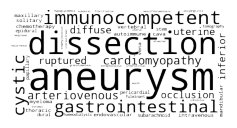

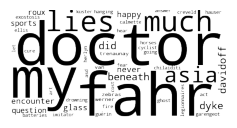

In [22]:
from matplotlib import pyplot as plt 

plt.clf()

for topic in topics:
    plt.figure(figsize=(2.8, 2.8))
    plt.imshow(topic.wordcloud)
    plt.axis("off")
    
    plt.savefig(OUTPUT_PATH + str(k) + 'topics/wordcloud'+str(topic.index)+'.png', transparent=True, bbox_inches='tight',pad_inches=0)

# 2. Validation

In [23]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

tfidf_model = TfidfVectorizer(max_df=MAX_DF)

tfidf = tfidf_model.fit_transform(corpus)
words_by_sentence = tfidf_model.inverse_transform(tfidf)

dictionary = Dictionary(words_by_sentence)

cm = CoherenceModel(topics=[topic.words for topic in topics], texts=words_by_sentence, dictionary=dictionary, coherence="c_v",topn=TOP_WORDS)

coherence = cm.get_coherence()
coherence_per_topic = cm.get_coherence_per_topic()

for i, c in enumerate(coherence_per_topic):
    topics[i].coherence = c
    print(topics[i].words[:TOP_WORDS])

print('Total coherence: ', coherence)
print('Coherence by topic: ', coherence_per_topic)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

['aneurysm', 'dissection', 'immunocompetent', 'gastrointestinal', 'cystic', 'cardiomyopathy', 'arteriovenous', 'diffuse', 'ruptured', 'uterine', 'occlusion', 'inferior', 'chemotherapy', 'vertebral', 'maxillary', 'thoracic', 'intravenous', 'solitary', 'endovascular', 'vena', 'myeloma', 'cava', 'autoimmune', 'pericardial', 'mandibular', 'subarachnoid', 'epidural', 'stem', 'papillary', 'dural', 'tomography', 'haemodialysis', 'granulomatous', 'hypoglycaemia', 'recurrence', 'month', 'fulminant', 'intravitreal', 'stromal', 'interstitial', 'neoplasm', 'alveolar', 'streptococcus', 'inhibitor', 'uterus', 'neurofibromatosis', 'polyangiitis', 'staphylococcus', 'subdural', 'vaginal']
['my', 'fahr', 'doctor', 'lies', 'much', 'van', 'sports', 'happy', 'trenaunay', 'roux', 'beneath', 'davidoff', 'did', 'encounter', 'question', 'werner', 'dyke', 'zebras', 'never', 'asia', 'glass', 'varied', 'stigma', 'fear', 'answer', 'batteries', 'creveld', 'hear', 'art', 'cyclist', 'legionnaires', 'solved', 'london'

In [24]:
with open(OUTPUT_PATH + '/results.txt', "a") as file:
    print('Hyper-parameters: \n{Language Model: ' + BERT_MODEL + ', Distance Threshold: '+str(DISTANCE_THRESHOLD) + ', TfIdf Threshold: '+str(MAX_DF) + ', cTfIdf Threshold: '+str(c_MAX_DF) + ', Top Words: '+str(TOP_WORDS) +'}', file=file)   
    print("Results: \n{Number of topics: "+str(len(topics)) + ', Vocabulary length: '+str(len(vocabulary)) + ', Total Coherence: '+str(coherence) + "}\n", file=file)  

    for topic in topics:
        print('Topic '+str(topic.index), file=file)    
        print('Number of sentences: '+str(topic.number_of_sentences), file=file)
        print('Coherence: '+str(topic.coherence), file=file)
        print('Top Words: '+str(topic.words[:TOP_WORDS]), file=file)  
        print('', file=file)

    print('----------------------------------------------------------------------------', file=file)  